# Определение возраста покупателей
# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

**Задача:** построить модель, которая по фотографии определит приблизительный возраст человека. 

В нашем распоряжении набор фотографий людей с указанием возраста.

**План выполнения проекта:**
- провести исследовательский анализ набора фотографий;
- подготовить данные к обучению;
- обучить нейронную сеть и рассчитайте её качество.

**Загрузка библиотек:**

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from PIL import Image 
import matplotlib.pyplot as plt

## Исследовательский анализ данных

**Загрузка данных:**

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


**Анализ данных:**

In [3]:
labels.sample(3)

,file_name,real_age
6661,006666.jpg,36
6024,006027.jpg,44
5202,005202.jpg,30


In [4]:
print('Информация о датафрейме \n')
labels.info()
print('\n Числовая характеристика (статистика)')
labels.describe()

Информация о датафрейме 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB

 Числовая характеристика (статистика)


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Вывод:** в датафрейме 7591 строк (объектов), 2 столбца: file_name - название изображения, real_age - возраст (целевой признак). Минимальный возраст - 1 год, максимальный - 100 лет, медиана - 29 лет, среднее - 31 год. Пропусков нет.

**Визуализация распределения количества изображений по возрастам**:

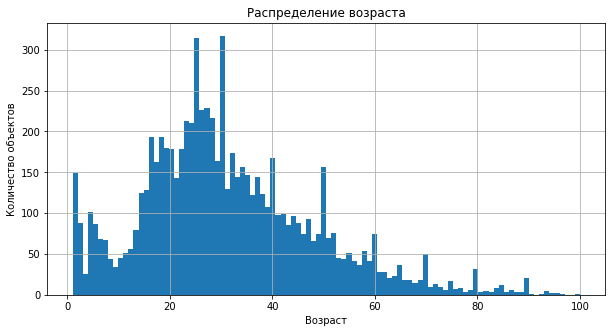

In [5]:
labels.hist(bins=100, figsize=(10, 5))
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество объектов')
plt.show()

**Вывод:** данные распределены нормально от 1 до 100 лет с небольшим всплеском ближе к нулю и смещением влево вершины «колокола». Пик приходится на значения возраста от 25 до 30 лет. Наблюдаются отдельные всплески в значениях возрастов, кратных 5, 10 - это может свидетельствовать о возможном округлении целевых значений возрастов при их разметке.

**Анализ изображений:**

Отобразим 15 фотографий и посмотрим, как устроен датасет:

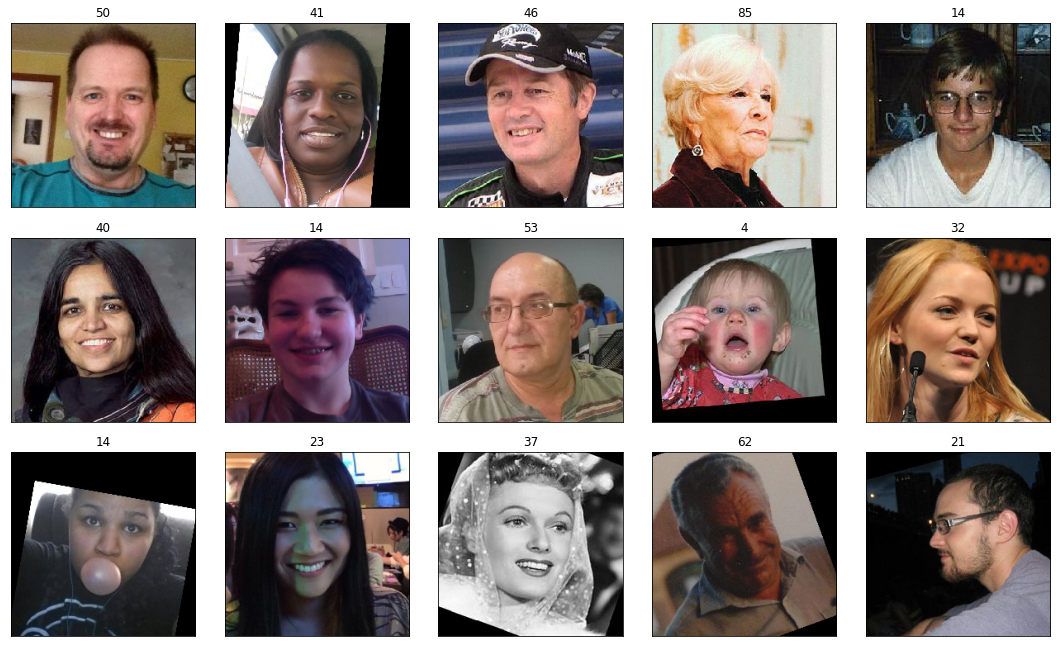

In [6]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

**Вывод:** на фотографиях присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор, капюшон и т.п., что может мешать модели предсказывать возраст. На некоторых изображениях имеются «растянутые» пиксели. Фотографии обработаны таким образом, что лица расположены практически вертикально и занимают бОльшую часть изображения - дополнительная обработка изображений не потребуется.

**Общий вывод по разделу:**
- в датафрейме 7591 строк (объектов), 2 столбца: file_name - название изображения, real_age - возраст (целевой признак). Минимальный возраст - 1 год, максимальный - 100 лет, медиана - 29 лет, среднее - 31 год;
- пропусков нет;
- данные распределены нормально от 1 до 100 лет с небольшим всплеском ближе к нулю и смещением влево вершины «колокола». Пик приходится на значения возраста от 25 до 30 лет. Наблюдаются отдельные всплески в значениях возрастов, кратных 5, 10 - это может свидетельствовать о возможном округлении целевых значений возрастов при их разметке;
- на фотографиях присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор, капюшон и т.п., что может мешать модели предсказывать возраст. На некоторых изображениях имеются «растянутые» пиксели. Фотографии обработаны таким образом, что лица расположены практически вертикально и занимают бОльшую часть изображения - дополнительная обработка изображений не потребуется.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

# Библиотеки
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from PIL import Image 
import matplotlib.pyplot as plt

# Функция подготовки тренировочных данных
def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

# Функция подготовки тестовых данных
def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

# Функция создания модели нейросети
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Функция обучения модели нейросети
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

**Результат вывода:**

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps

Epoch 1/5
190/190 - 77s - loss: 230.2865 - mae: 10.8182 - val_loss: 538.1803 - val_mae: 18.0176
Epoch 2/5
190/190 - 38s - loss: 62.6906 - mae: 5.9863 - val_loss: 586.8941 - val_mae: 19.0572
Epoch 3/5
190/190 - 38s - loss: 29.8775 - mae: 4.2176 - val_loss: 390.8489 - val_mae: 14.9614
Epoch 4/5
190/190 - 38s - loss: 18.9543 - mae: 3.3958 - val_loss: 98.2562 - val_mae: 7.5863
Epoch 5/5
190/190 - 38s - loss: 14.8844 - mae: 3.0125 - val_loss: 81.7359 - val_mae: 6.8225

48/48 - 8s - loss: 81.7359 - mae: 6.8225

```

**Вывод:** построена и обучена свёрточная нейронная сеть ResNet50 на наборе данных с лицами людей. Для этого создано четыре функции:
- загрузки обучающей выборки load_train();
- загрузки валидационной выборки load_test();
- создания модели create_model();
- запуска модели train_model().

При обучении использовалась функция потерь MSE. **Критерий качества - значение MAE на тестовой выборке не больше 8 - достигнут:** 

**МАЕ = 6.8225**. 

Цель обучения нейросети достигнута.

## Анализ обученной модели

Построена и обучена модель с помощью архитектуры ResNet50 на наборе данных с лицами людей (фотографии). Использован оптимизатор Adam со скоростью обучения 0.0001, в качестве функции потерь использовалась MSЕ (среднеквадратичная ошибка). Качество модели оценено метрикой MAE. **Критерий качества - значение MAE на тестовой выборке не больше 8 - достигнут: МАЕ = 6.8225**. Т.к. MAE измеряется в абсолютных величинах, то полученый результат означает, что созданная модель ошибается в предсказании возраста человека по его фотографии не более, чем на 6.8225 лет.

Согласно поставленной задачи, можно сделать вывод: фотофиксация в прикассовой зоне для определения возраста клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы - разработанная модель подходит;
- контролировать добросовестность кассиров при продаже алкоголя - разработанная модель не подойдет.

Задача: построить модель, которая по фотографии определит приблизительный возраст человека - выполнена.

## Общий вывод

**ЭТАП 1.** Исследовательский анализ данных.

Загружены данные:

- в датафрейме 7591 строк (объектов), 2 столбца: file_name - название изображения, real_age - возраст (целевой признак). Минимальный возраст - 1 год, максимальный - 100 лет, медиана - 29 лет, среднее - 31 год;
- пропусков нет;
- данные распределены нормально от 1 до 100 лет с небольшим всплеском ближе к нулю и смещением влево вершины «колокола». Пик приходится на значения возраста от 25 до 30 лет. Наблюдаются отдельные всплески в значениях возрастов, кратных 5, 10 - это может свидетельствовать о возможном округлении целевых значений возрастов при их разметке;
- на фотографиях присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор, капюшон и т.п., что может мешать модели предсказывать возраст. На некоторых изображениях имеются «растянутые» пиксели. Фотографии обработаны таким образом, что лица расположены практически вертикально и занимают бОльшую часть изображения - дополнительная обработка изображений не потребуется.

**ЭТАП 2.** Обучение модели.

Построена и обучена нейронная сеть с архитектурой ResNet50 на наборе данных с лицами людей (фотографии). Для этого создано четыре функции:
- загрузки обучающей выборки load_train();
- загрузки валидационной выборки load_test();
- создания модели create_model();
- запуска модели train_model().

Использован оптимизатор Adam со скоростью обучения 0.0001, в качестве функции потерь использовалась MSЕ (среднеквадратичная ошибка). Качество модели оценено метрикой MAE.

**Критерий качества - значение MAE на тестовой выборке не больше 8 - достигнут:** 

**МАЕ = 6.8225**. 

**Цель обучения нейросети достигнута.**

**ЭТАП 3.** Анализ обученной модели.

Критерий качества - значение MAE на тестовой выборке не больше 8 - достигнут: МАЕ = 6.8225. Т.к. MAE измеряется в абсолютных величинах, то полученый результат означает, что созданная модель ошибается в предсказании возраста человека по его фотографии не более, чем на 6.8225 лет.

Согласно поставленной задачи, можно сделать вывод: фотофиксация в прикассовой зоне для определения возраста клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы - разработанная модель подходит;
- контролировать добросовестность кассиров при продаже алкоголя - разработанная модель не подойдет.

**Задача: построить модель, которая по фотографии определит приблизительный возраст человека - выполнена.**